## step 1: Set paths for dotnet-interactive and try projects

In [1]:
$dotnetInteractivePath="D:\microsoft\dotnet\interactive"
$tryDotnetPath="D:\microsoft\dotnet\try"
$monacoEditorProject="$tryDotnetPath\src\Microsoft.TryDotNet"
$mockMsLearnServer="$tryDotnetPath\src\microsoft-learn-mock"

## step 2: Build Javascript projects

In [ ]:
Set-Location -Path $dotnetInteractivePath

if ($IsWindows) {
    Invoke-Expression "$dotnetInteractivePath\build-js.cmd"
}else {
    Invoke-Expression "$dotnetInteractivePath\build-js.sh"
}

## step 3: Create the NuGet package CSharpProject
The following script will copy the generated packages into from C:\temp\packages\

In [ ]:
Set-Location -Path $dotnetInteractivePath

Invoke-Expression ".\repack.ps1"

## step 4: Create a new NuGet Feed in try dotnet pointing to this path

In [33]:
# Navigate to the directory containing the NuGet.config
Set-Location -Path $tryDotnetPath

# Add a new package source
$nugetConfigPath = Join-Path $tryDotnetPath 'NuGet.config'
[xml]$nugetConfig = Get-Content $nugetConfigPath

$newPackageSource = $nugetConfig.CreateElement("add")
$newPackageSource.SetAttribute("key", "LocalPackages")
$newPackageSource.SetAttribute("value", "C:\temp\packages")

$packageSourcesNode = $nugetConfig.SelectSingleNode('configuration/packageSources')
$packageSourcesNode.AppendChild($newPackageSource) > $null

$nugetConfig.Save($nugetConfigPath)

## 5: Update NuGet package Microsoft.DotNet.Interactive.CSharpProject to use the one created in previous steps


In [4]:
# Define the path to the Directory.Packages.props file
$packagesPropsPath = Join-Path $tryDotnetPath "Directory.Packages.props"

# Load the XML content of the Directory.Packages.props file
[xml]$packagesProps = Get-Content $packagesPropsPath

# Define the namespace to handle the default namespace in the document
$namespaceManager = New-Object System.Xml.XmlNamespaceManager($packagesProps.NameTable)
$namespaceManager.AddNamespace("msb", "http://schemas.microsoft.com/developer/msbuild/2003")

# Ensure that the ItemGroup element exists
$itemGroup = $packagesProps.SelectSingleNode("msb:Project/msb:ItemGroup", $namespaceManager)
if ($itemGroup -eq $null) {
    $itemGroup = $packagesProps.CreateElement("ItemGroup", $namespaceManager.LookupNamespace("msb"))
    $packagesProps.DocumentElement.AppendChild($itemGroup)
}

# Check if the PackageVersion element for the package already exists
$packageRef = $itemGroup.SelectSingleNode("msb:PackageVersion[@Include='Microsoft.DotNet.Interactive.CSharpProject']", $namespaceManager)

if ($packageRef -eq $null) {
    # If the package reference doesn't exist, create it
    $newPackageRef = $packagesProps.CreateElement("PackageVersion", $namespaceManager.LookupNamespace("msb"))
    $newPackageRef.SetAttribute("Include", "Microsoft.DotNet.Interactive.CSharpProject")
    $newPackageRef.SetAttribute("Version", "2.0.0")
    $itemGroup.AppendChild($newPackageRef)
} else {
    # If it exists, just update the version
    $packageRef.SetAttribute("Version", "2.0.0")
}

# Save the changes back to the Directory.Packages.props file
$packagesProps.Save($packagesPropsPath)


## 6: Build trydotnet.js which handles events from Monaco Editor

In [ ]:
Set-Location -Path $tryDotnetPath

if ($IsWindows) {
    Invoke-Expression "$tryDotnetPath\build-js.cmd"
}else {
    Invoke-Expression "$tryDotnetPath\build-js.sh"
}

## step 7: Build of trydotnet service

In [ ]:
Set-Location -Path $tryDotnetPath

Invoke-Expression "$tryDotnetPath\build.cmd"

## step 8: Run the Mocaco Editor

In [ ]:
Set-Location -Path $monacoEditorProject

## This will launch the editor at https://localhost:7061/editor
dotnet run --no-build --project "Microsoft.TryDotNet.csproj" --configuration Release --launch-profile "Microsoft.TryDotNet"

## step 9: Verify Monaco Editor is running

In [ ]:
# Open the default web browser at the given URL
Start-Process "https://localhost:7061/editor"

## step 10: Build the mock project that represents MS Learn server

In [ ]:
Set-Location -Path $mockMsLearnServer

npm ci

npm run buildProd

## step 11: Launch the mock MS Learn server

In [ ]:
Set-Location -Path $mockMsLearnServer

npx http-server -p 7063

## step 12: Open the mock MS Learn webpage with the editor

In [ ]:
Start-Process "http://127.0.0.1:7063/site/DocsHost.html?trydotnetUrl=https://localhost:7061/api/trydotnet.min.js&trydotnetOrigin=https://localhost:7061/"

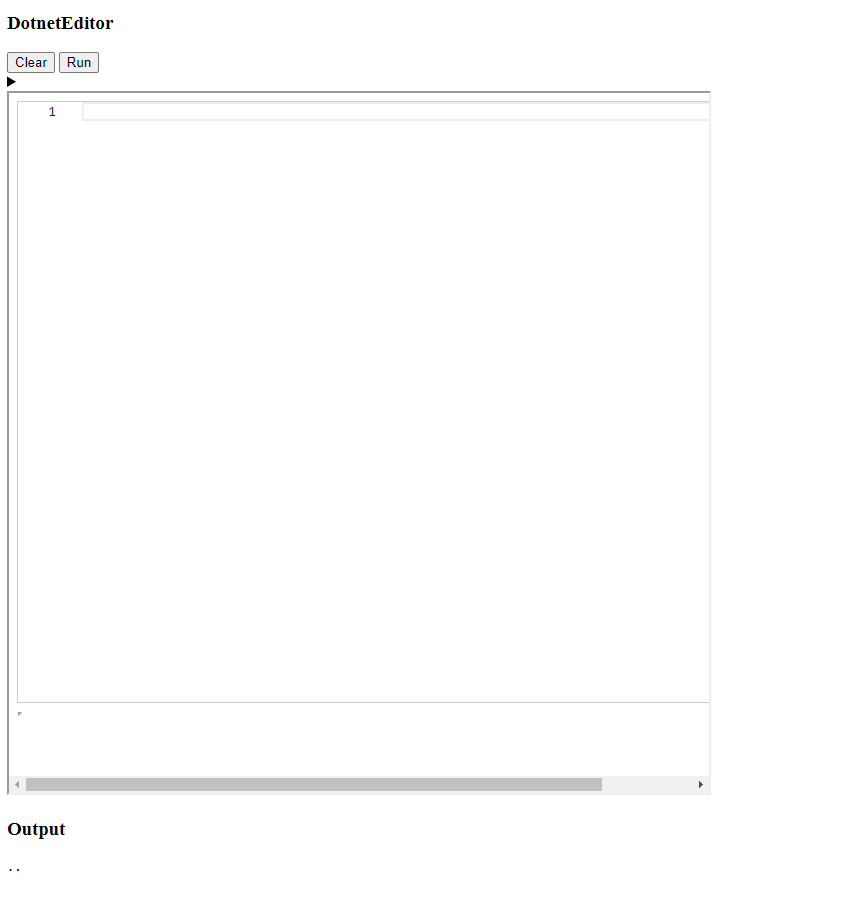

## Try .NET / Microsoft Learn flow diagram

The diagram available through the link below provides a comprehensive of the interaction between Try .NET service (trydotnet.microsoft.com) and a host page (learn.microsoft.com).

https://github.com/dotnet/interactive/tree/main/src/Microsoft.DotNet.Interactive.CSharpProject#try-net--microsoft-learn-flow

The core of Try .NET is powered by the `CSharpProjectKernel`, which serves as the backend for .NET Interactive.